
### <font color='blue'>Prevendo o Retorno de Aplicações Financeiras com Temporal Fusion Transformer</font>

## Instalando e Carregando os Pacotes

In [3]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [4]:
# https://www.tensorflow.org/
!pip install -q tensorflow==2.12.0

In [5]:
# https://pypi.org/project/yfinance/
!pip install -q yfinance==0.2.22

In [6]:
# https://pypi.org/project/ta/
!pip install -q ta==0.10.2

In [7]:
# Imports
import ta
import sklearn
import pandas as pd
import numpy as np
import tensorflow
from tensorflow import keras
from keras import layers
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib import cycler
import warnings
warnings.filterwarnings("ignore")

In [8]:
plt.style.use('seaborn')

## Função Para Extração dos Dados em Tempo Real

https://finance.yahoo.com/

In [10]:
# Função
def extrai_dados(ticker):
    
    # Busca todos os dados a partir de 01/01/1990
    dados = yf.download(ticker, start = "1990-01-01")
    
    # Colunas do dataframe
    dados.columns = ["open", "high", "low", "close", "adj close", "volume"]
    
    # Data como índice
    dados.index.name = "date"
    
    return dados

## Função Para Engenharia de Atributos de Dados Financeiros

O código abaixo define uma função de engenharia de atributos para um dataframe que representa dados de um ativo financeiro (ações) com colunas para 'open' (preço de abertura), 'high' (máximo do dia), 'low' (mínimo do dia), 'close' (preço de fechamento) e 'volume'. 

A engenharia de atributos é uma técnica usada para criar novas variáveis com base em variáveis existentes, a fim de melhorar o desempenho dos modelos de Machine Learning. Aqui está uma descrição detalhada do que o código faz:

Primeiro, cria uma cópia do dataframe para não modificar o dataframe original.

Em seguida, cria uma nova coluna 'retorno', que representa a mudança percentual do preço de fechamento em relação ao dia anterior.

As colunas 'open', 'high', 'low', 'close' e 'volume' são então deslocadas para baixo (shifted) em uma unidade, criando as colunas 'op', 'hi', 'lo', 'clo' e 'vol'. Isso significa que a linha 'i' dessas novas colunas contém os valores da linha 'i-1' das colunas originais.

A função também cria médias móveis simples (Simple Moving Average - SMA) para o preço de fechamento com janelas de 15 e 60 dias, deslocadas por uma unidade. 

A volatilidade, representada como o desvio padrão das mudanças percentuais do preço de fechamento, é calculada para as janelas de 15 e 60 dias, também deslocadas por uma unidade. Esse índice é conhecido como Moving Standard Deviation (MSD).

Em seguida, a função cria o Volume Weighted Average Price (VWAP) com uma janela de 5 dias. O VWAP é uma medida de preço médio ponderado pelo volume.

A função também adiciona o indicador RSI (Relative Strength Index) com uma janela de 5 dias. O RSI é um indicador de momento que mede a velocidade e a mudança de movimentos de preço.

Finalmente, a função remove todas as linhas que contêm valores NA (que foram criados ao deslocar as colunas e calcular médias móveis e RSI com janelas).

Em resumo, essa função cria várias novas características técnicas comumente usadas na análise de ativos financeiros, todas deslocadas por uma unidade, para evitar o uso de informações futuras (ou seja, vazamento de dados) no modelo de Machine Learning.

In [11]:
# Função para engenharia de atributos
def func_engenharia_atributos(df):

    # Cópia do dataframe
    df_copy = df.copy()

    # Cria a variável com o retorno (mudança percentual do fechamento - close)
    # Essa será nossa variável alvo
    df_copy["retorno"] = df_copy["close"].pct_change(1)

    # Shift das colunas de preço do ativo financeiro
    df_copy["op"] = df_copy["open"].shift(1)
    df_copy["hi"] = df_copy["high"].shift(1)
    df_copy["lo"] = df_copy["low"].shift(1)
    df_copy["clo"] = df_copy["close"].shift(1)

    # Shift da coluna Volume
    df_copy["vol"] = df_copy["volume"].shift(1)

    # Simple Moving Average (SMA)
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)

    # Moving Standard Deviation (MSD) - Volatilidade
    df_copy["MSD 15"] = df_copy["retorno"].rolling(15).std().shift(1)
    df_copy["MSD 60"] = df_copy["retorno"].rolling(60).std().shift(1)

    # Volume Weighted Average Price (VWAP)
    vwap = ta.volume.VolumeWeightedAveragePrice(high = df['high'],
                                                low = df['low'],
                                                close = df['close'],
                                                volume = df['volume'],
                                                window = 5)
    
    df_copy["VWAP"] = vwap.vwap.shift(1)

    # Relative Strength Index (RSI)
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window = 5, fillna = False)
    
    df_copy["RSI"] = RSI.rsi().shift(1)

    return df_copy.dropna()

## Extração e Processamento dos Dados

In [12]:
# Extração dos dados
df = extrai_dados("MSFT")

[*********************100%***********************]  1 of 1 completed


In [13]:
# Engenharia de atributos
df = func_engenharia_atributos(df)

In [14]:
df

,open,high,low,close,adj close,volume,retorno,op,hi,lo,clo,vol,SMA 15,SMA 60,MSD 15,MSD 60,VWAP,RSI
date,,,,,,,,,,,,,,,,,,
1990-03-29,0.766493,0.782986,0.763889,0.767361,0.477711,64785600,-0.004504,0.779514,0.779514,0.753472,0.770833,99532800.0,0.768229,0.681944,0.019495,0.020194,0.772823,48.231148
1990-03-30,0.763889,0.770833,0.758681,0.769097,0.478792,36691200,0.002262,0.766493,0.782986,0.763889,0.767361,64785600.0,0.770197,0.684404,0.017916,0.020222,0.771632,44.647708
1990-04-02,0.762153,0.780382,0.758681,0.774306,0.482035,74059200,0.006773,0.763889,0.770833,0.758681,0.769097,36691200.0,0.772164,0.686588,0.017916,0.019941,0.771327,47.103935
1990-04-03,0.782986,0.807292,0.781250,0.805556,0.501489,84643200,0.040359,0.762153,0.780382,0.758681,0.774306,74059200.0,0.773669,0.689120,0.017560,0.019607,0.770822,54.651644
1990-04-04,0.805556,0.824653,0.802083,0.812500,0.505812,79646400,0.008620,0.782986,0.807292,0.781250,0.805556,84643200.0,0.778183,0.692014,0.019132,0.020116,0.776124,78.092875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-03,339.190002,340.899994,336.570007,337.989990,337.989990,12508700,-0.007488,337.750000,342.730011,337.200012,340.540009,26823800.0,336.110000,314.281499,0.015559,0.016990,335.219746,63.311139
2023-07-05,335.089996,341.649994,334.730011,338.149994,338.149994,18172400,0.000473,339.190002,340.899994,336.570007,337.989990,12508700.0,336.856665,315.175666,0.015790,0.016962,336.509995,54.913200
2023-07-06,337.299988,342.989990,335.500000,341.269989,341.269989,28161200,0.009227,335.089996,341.649994,334.730011,338.149994,18172400.0,337.276664,315.951499,0.015370,0.016705,337.644316,55.377442


> Divisão dos Dados em Treino, Validação e Teste

In [15]:
# Percentual de split de treino e validação
split = int(0.85*len(df))
split_val = int(0.95*len(df))

In [16]:
df.columns

Index(['open', 'high', 'low', 'close', 'adj close', 'volume', 'retorno', 'op',
       'hi', 'lo', 'clo', 'vol', 'SMA 15', 'SMA 60', 'MSD 15', 'MSD 60',
       'VWAP', 'RSI'],
      dtype='object')

In [17]:
# Dataset de treino
x_treino = df[['VWAP','RSI','SMA 15','SMA 60','MSD 15','MSD 60','op','hi','lo','clo','vol']].iloc[:split,:]
y_treino = df[['retorno']].iloc[:split,:]

In [18]:
# Dataset de validação
x_valid = df[['VWAP','RSI','SMA 15','SMA 60','MSD 15','MSD 60','op','hi','lo','clo','vol']].iloc[split:split_val,:]
y_valid = df[['retorno']].iloc[split:split_val,:]

In [19]:
# Dataset de teste
x_teste = df[['VWAP','RSI','SMA 15','SMA 60','MSD 15','MSD 60','op','hi','lo','clo','vol']].iloc[split_val:,:]
y_teste = df[['retorno']].iloc[split_val:,:]

> Padronização

In [20]:
# Cria o padronizador
sc = StandardScaler()

In [21]:
# Fit e transform nos dados de treino
x_treino_sc = sc.fit_transform(x_treino)

In [22]:
# Transform nos dados de validação
x_valid_sc = sc.transform(x_valid)

In [23]:
# Transform nos dados de teste
x_teste_sc = sc.transform(x_teste)

## Ajuste no Formato dos Dados

Este código abaixo define uma função que é usada para transformar séries de tempo para um formato adequado para treinamento de Redes Neurais Recorrentes (RNNs), como Long Short Term Memory (LSTM) ou GRU. Os modelos RNN precisam de um formato de entrada específico porque levam em conta a sequência temporal dos dados.

O código realiza as seguintes operações:

Primeiro, verifica se as entradas X_s e y_s possuem a mesma extensão. Se não, imprime um aviso.

Em seguida, cria a variável X_train. Essa variável é criada iterando sobre todas as variáveis em X_s e criando 'janelas' de tamanho lag para cada uma delas. Ou seja, para cada ponto no tempo i, ele pega os lag pontos anteriores para cada variável e armazena isso numa lista. Ao final do processo, temos uma lista de listas para cada variável.

X_train é então transformado em um array NumPy e as dimensões são reordenadas. A chamada ao método swapaxes é feita duas vezes para garantir que as dimensões estejam na ordem correta para a entrada da RNN. A ordem final é (amostras, passos de tempo, características).

Depois, a função cria y_train que contém a variável alvo correspondente para cada janela em X_train. Ele faz isso iterando sobre y_s de lag até o final e armazenando cada valor em uma lista.

Por fim, y_train é convertido em um array NumPy usando o método concatenate, que combina uma lista de arrays NumPy em um único array.

A função retorna X_train e y_train, que estão agora em um formato adequado para serem usados para treinar uma RNN. A ideia geral aqui é que, para prever o valor de y em um certo ponto no tempo, você usará os lag pontos anteriores de X.

In [24]:
# Função para ajustar o formato dos dados
def ajusta_formato_dados(X_s, y_s, lag):

    if len(X_s) != len(y_s):
        print("Warnings")

    X_train = []
    
    for variable in range(0, X_s.shape[1]):
        
        X = []
        
        for i in range(lag, X_s.shape[0]):
            X.append(X_s[i-lag:i, variable])
        
        X_train.append(X)
    
    X_train, np.array(X_train)
    
    X_train = np.swapaxes(np.swapaxes(X_train, 0, 1), 1, 2)

    y_train = []
    
    for i in range(lag, y_s.shape[0]):
        y_train.append(y_s[i, :].reshape(-1,1).transpose())
    
    y_train = np.concatenate(y_train, axis = 0)
    
    return X_train, y_train

In [25]:
# Valor do Lag
lag = 15

In [26]:
# Aplica a função nos dados de treino
x_treino_final, y_treino_final = ajusta_formato_dados(x_treino_sc, y_treino.values, lag)

In [27]:
# Aplica a função nos dados de validação
x_valid_final, y_valid_final = ajusta_formato_dados(x_valid_sc, y_valid.values, lag)

In [28]:
# Aplica a função nos dados de teste
x_teste_final, y_teste_final = ajusta_formato_dados(x_teste_sc, y_teste.values, lag)

In [29]:
print(f"Shape dos dados de treino: {x_treino_final.shape}")
print(f"Shape dos dados de validação: {x_valid_final.shape}")
print(f"Shape dos dados de teste: {x_teste_final.shape}")

Shape dos dados de treino: (7110, 15, 11)
Shape dos dados de validação: (823, 15, 11)
Shape dos dados de teste: (405, 15, 11)


## Construção do Modelo Temporal Fusion Transformer

(https://keras.io/examples/timeseries/timeseries_transformer_classification

In [30]:
# Função do transformer encoder
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout = 0):
    
    # Normalização
    x = layers.LayerNormalization(epsilon = 1e-6)(inputs)
    
    # Atenção
    x = layers.MultiHeadAttention(key_dim = head_size, num_heads = num_heads, dropout = dropout)(x, x, x)
    
    # Dropout
    x = layers.Dropout(dropout)(x)
    
    # Camadas e dados
    res = x + inputs

    # Feed Forward 
    x = layers.LayerNormalization(epsilon = 1e-6)(res)
    x = layers.Conv1D(filters = ff_dim, kernel_size = 1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters = inputs.shape[-1], kernel_size = 1)(x)
    
    return x + res

A função abaixo é usada para construir o modelo final com LSTM, GRU e Transformer.

In [31]:
# Função de criação do modelo
def cria_modelo(input_shape, 
                head_size, 
                num_heads, 
                ff_dim, 
                num_transformer_blocks, 
                mlp_units, 
                dropout = 0, 
                mlp_dropout = 0):
    
    inputs = keras.Input(shape = input_shape)
    
    x = inputs
    
    x = layers.LSTM(10, return_sequences = True)(x)
    
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    x = layers.GRU(100, return_sequences = False)(x)
    
    x = layers.Dropout(mlp_dropout)(x)
    
    x = layers.Dense(mlp_units, activation = "relu")(x)
    
    outputs = layers.Dense(1)(x)
    
    return keras.Model(inputs, outputs)

In [32]:
# Shape de entrada
input_shape = x_treino_final.shape[1:]

In [33]:
# Cria o modeloo
modelo = cria_modelo(input_shape,
                     head_size = 16,
                     num_heads = 1,
                     ff_dim = 4,
                     num_transformer_blocks = 1,
                     mlp_units = 125,
                     dropout = 0.1,
                     mlp_dropout = 0.25)

In [34]:
# Compila o modelo
modelo.compile(loss = "mean_squared_error", optimizer = keras.optimizers.Adam())

In [35]:
modelo.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15, 11)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 15, 10)       880         ['input_1[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 15, 10)      20          ['lstm[0][0]']                   
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 15, 10)      698         ['layer_normalization[0][0]',

In [36]:
# Callbacks
callbacks = [keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)]

In [37]:
%%time

# Treinamento do modelo
modelo.fit(x_treino_final,
           y_treino_final,
           validation_data = (x_valid_final, y_valid_final),
           epochs = 20,
           batch_size = 64,
           callbacks = callbacks)

Epoch 1/20
112/112 [==============================] - 3s 13ms/step - loss: 0.0033 - val_loss: 4.9044e-04
Epoch 2/20
112/112 [==============================] - 1s 10ms/step - loss: 7.8670e-04 - val_loss: 3.9908e-04
Epoch 3/20
112/112 [==============================] - 1s 10ms/step - loss: 5.9770e-04 - val_loss: 4.0056e-04
Epoch 4/20
112/112 [==============================] - 1s 10ms/step - loss: 5.4764e-04 - val_loss: 4.4321e-04
Epoch 5/20
112/112 [==============================] - 1s 10ms/step - loss: 5.0977e-04 - val_loss: 6.0422e-04
Epoch 6/20
112/112 [==============================] - 1s 10ms/step - loss: 4.9419e-04 - val_loss: 4.7029e-04
Epoch 7/20
112/112 [==============================] - 1s 10ms/step - loss: 4.7172e-04 - val_loss: 6.4812e-04
CPU times: user 20.5 s, sys: 1.88 s, total: 22.3 s
Wall time: 10.2 s


<AxesSubplot:>

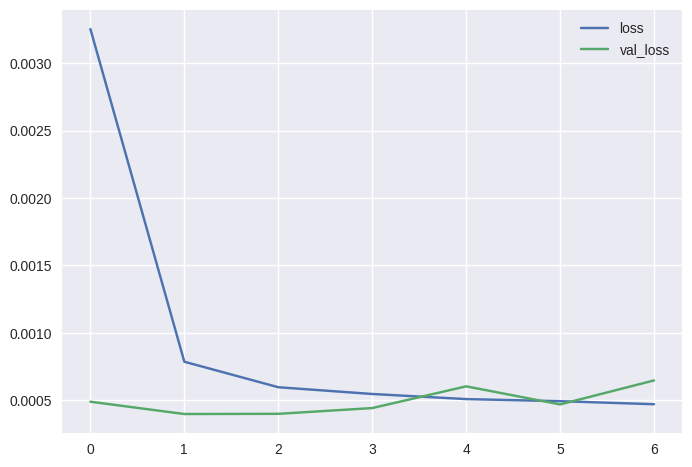

In [38]:
pd.DataFrame(modelo.history.history).plot()

In [39]:
pred = modelo.predict(x_teste_final)

13/13 [==============================] - 1s 3ms/step


In [40]:
score = np.sqrt(metrics.mean_squared_error(pred, y_teste_final))

In [41]:
print("Score (RMSE): {}".format(score))

Score (RMSE): 0.020599476797915933


## Previsões e Cálculo do Retorno

A linha de código abaixo está realizando a seguinte operação:

- Está prevendo valores usando o modelo treinado chamado modelo para a entrada x_treino_final. Essa previsão retorna um array NumPy.

- Está criando um array NumPy de zeros com dimensões [lag,1]. A variável lag é geralmente um número inteiro que se refere a um período de atraso ou defasagem (por exemplo, se você está trabalhando com séries temporais e deseja considerar os 5 valores anteriores, o lag seria 5).

- Depois disso, está concatenando o array de zeros com as previsões do modelo ao longo do eixo 0 (ou seja, verticalmente). A razão para fazer isso é para ajustar o formato dos dados, porque você teve um deslocamento de lag ao criar os dados de entrada para o modelo, então agora precisa preencher esses primeiros lag pontos nos dados de saída.

Repetimos o mesmo com dados de validação e teste e então concatenamos.

In [42]:
y_pred_treino = np.concatenate((np.zeros([lag,1]), modelo.predict(x_treino_final)), axis = 0)

223/223 [==============================] - 1s 4ms/step


In [43]:
y_pred_valid = np.concatenate((np.zeros([lag,1]), modelo.predict(x_valid_final)), axis = 0)

26/26 [==============================] - 0s 3ms/step


In [44]:
y_pred_teste = np.concatenate((np.zeros([lag,1]), modelo.predict(x_teste_final)), axis = 0)

13/13 [==============================] - 0s 3ms/step


In [45]:
# Concatena as previsões em treino, valid e teste como previsão final
df["prediction"] = np.concatenate((y_pred_treino, y_pred_valid, y_pred_teste), axis = 0)

In [46]:
df.tail()

,open,high,low,close,adj close,volume,retorno,op,hi,lo,clo,vol,SMA 15,SMA 60,MSD 15,MSD 60,VWAP,RSI,prediction
date,,,,,,,,,,,,,,,,,,,
2023-07-03,339.190002,340.899994,336.570007,337.989990,337.989990,12508700,-0.007488,337.750000,342.730011,337.200012,340.540009,26823800.0,336.110000,314.281499,0.015559,0.016990,335.219746,63.311139,-0.000284
2023-07-05,335.089996,341.649994,334.730011,338.149994,338.149994,18172400,0.000473,339.190002,340.899994,336.570007,337.989990,12508700.0,336.856665,315.175666,0.015790,0.016962,336.509995,54.913200,-0.000517
2023-07-06,337.299988,342.989990,335.500000,341.269989,341.269989,28161200,0.009227,335.089996,341.649994,334.730011,338.149994,18172400.0,337.276664,315.951499,0.015370,0.016705,337.644316,55.377442,-0.000444
2023-07-07,339.320007,341.790009,337.000000,337.220001,337.220001,21185300,-0.011867,337.299988,342.989990,335.500000,341.269989,28161200.0,337.741996,316.816165,0.015429,0.016672,338.616719,64.329740,-0.000440
2023-07-10,334.600006,335.230011,327.589996,331.829987,331.829987,31765872,-0.015984,339.320007,341.790009,337.000000,337.220001,21185300.0,337.733997,317.722665,0.015638,0.016449,339.267291,48.531365,-0.000586


A linha de código abaixo está criando uma nova coluna chamada "strategy" no DataFrame df. Os valores para essa coluna são calculados tomando a coluna "retorno" e multiplicando-a pelo sinal da previsão do dia anterior (obtido através de df["prediction"].shift(1)).

A função np.sign retorna -1 se o número for negativo, 0 se o número for zero e 1 se o número for positivo.

Ao usar shift(1), você está pegando os valores de "prediction" do dia anterior, porque shift(1) desloca os valores para baixo em uma linha.

Em outras palavras, a estratégia aqui é que se a previsão do dia anterior era positiva, então você assume uma posição longa (compra) e seu retorno é simplesmente o retorno do ativo. Se a previsão do dia anterior era negativa, então você assume uma posição curta (vende), e o seu retorno é o negativo do retorno do ativo (porque quando você vende um ativo a descoberto, você ganha dinheiro quando o preço cai).

É uma estratégia de negociação baseada nas previsões do dia anterior. Essa estratégia presume que você pode perfeitamente cronometrar suas negociações no final do dia com base nas previsões do dia anterior.

Nota: A execução dessa estratégia seria um pouco mais complicada e incluiria custos de transação.

In [47]:
# Calcula a estratégia
df["strategy"] = df["retorno"] * np.sign(df["prediction"].shift(1))

In [48]:
df.tail()

,open,high,low,close,adj close,volume,retorno,op,hi,lo,clo,vol,SMA 15,SMA 60,MSD 15,MSD 60,VWAP,RSI,prediction,strategy
date,,,,,,,,,,,,,,,,,,,,
2023-07-03,339.190002,340.899994,336.570007,337.989990,337.989990,12508700,-0.007488,337.750000,342.730011,337.200012,340.540009,26823800.0,336.110000,314.281499,0.015559,0.016990,335.219746,63.311139,-0.000284,0.007488
2023-07-05,335.089996,341.649994,334.730011,338.149994,338.149994,18172400,0.000473,339.190002,340.899994,336.570007,337.989990,12508700.0,336.856665,315.175666,0.015790,0.016962,336.509995,54.913200,-0.000517,-0.000473
2023-07-06,337.299988,342.989990,335.500000,341.269989,341.269989,28161200,0.009227,335.089996,341.649994,334.730011,338.149994,18172400.0,337.276664,315.951499,0.015370,0.016705,337.644316,55.377442,-0.000444,-0.009227
2023-07-07,339.320007,341.790009,337.000000,337.220001,337.220001,21185300,-0.011867,337.299988,342.989990,335.500000,341.269989,28161200.0,337.741996,316.816165,0.015429,0.016672,338.616719,64.329740,-0.000440,0.011867
2023-07-10,334.600006,335.230011,327.589996,331.829987,331.829987,31765872,-0.015984,339.320007,341.790009,337.000000,337.220001,21185300.0,337.733997,317.722665,0.015638,0.016449,339.267291,48.531365,-0.000586,0.015984


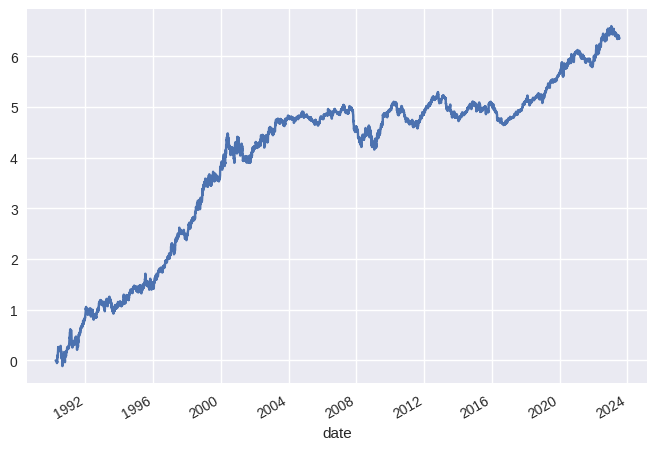

In [49]:
# Plot do acumulado
df["strategy"].iloc[:].cumsum().plot()
plt.show()

Investir nas ações da Microsoft pode gerar retorno positivo ao longo do tempo.